In [30]:
%reload_ext autoreload
%autoreload 2

import sys
import numpy as np
import matplotlib.pyplot as plt
import cebra.datasets
from cebra import CEBRA
import os
import numpy as np
import pandas as pd
import main_funcs as mfun
import utils_funcs as utils
import plot_funcs as pfun
import pickle
from scipy import stats
from itertools import compress
import seaborn as sns
from sklearn import preprocessing
import matplotlib.gridspec as gridspec
import matplotlib as mpl
import glob as glob
import warnings
import torch
warnings.filterwarnings("ignore", category=RuntimeWarning) 
warnings.filterwarnings("ignore", category= FutureWarning) 

#paths
savefigpath  = 'C:\\Users\\Huriye\\Documents\\code\\clapfcstimulation\\figs\\2024-02-29'
'G:\\My Drive\\Manuscripts\\3 CLAStPFC\\figuresForCLAStPFC\\figurePanels\\'
analysispath = 'C:\\Users\\Huriye\\Documents\\code\\clapfcstimulation\\analysis\\'

In [40]:
interestedCohort = 'Chrimson'
interestedTrainedLevel = 'Naive'
resposiveness = 'Visual'
stimType = ['Visual','Opto', 'Visual + Opto']
sortType = 'None'
fRate = 30
preStimFrame = round(2.35*fRate)
analysisTimeWindow  = 2
postStimFrame = preStimFrame + round(analysisTimeWindow*fRate)

plotDatas = pfun. createTrialvsTraceMatrix(stimType, sortType, interestedCohort,
                                                   trainedLevel = interestedTrainedLevel,
                                                    condition = resposiveness)

Cells are not sorted
Cells are not sorted
Cells are not sorted


In [41]:
# neural_data = np.vstack(plotDatas)
# neural_data = neural_data[:,preStimFrame:postStimFrame]
stimID = [[i, stimType.index(stim)] for i, stim in enumerate(stimType) for _ in range(len(plotDatas[i]))]
stimID = np.array(stimID)
stimID = np.hstack([stimID, np.zeros((stimID.shape[0], 1))])
stimID[:,2] = (stimID[:,0])+(stimID[:,1])

filtered_plotDatas = []
filtered_stimID = []
current_index = 0  # Keeps track of the current index in stimID

for data in plotDatas:
    segment_data = data[:, preStimFrame:postStimFrame]
    
    # Create a mask for rows without NaNs in the segment
    mask = ~np.isnan(segment_data).any(axis=1)
    
    # Apply the mask to the original data (if you want to keep the whole row based on this segment)
    filtered_data = segment_data[mask]
    filtered_plotDatas.append(filtered_data)
    
    # Apply the same mask to the corresponding segment of stimID
    segment_stimID = stimID[current_index : current_index + len(data)]  # Selects the corresponding segment of stimID
    filtered_segment_stimID = segment_stimID[mask]  # Apply mask
    filtered_stimID.extend(filtered_segment_stimID)  # Extend the filtered list
    
    current_index += len(data)  # Update the index for the next segment

# Stack the filtered data arrays
neural_data = np.vstack(filtered_plotDatas)

# If stimID is a numpy array and you want the filtered_stimID to be a numpy array too
stimID = np.array(filtered_stimID)

data1 = neural_data[stimID[:,0] == 0]
data2 = neural_data[stimID[:,0] == 1]
data3 = neural_data[stimID[:,0] == 2]

data1.shape, data2.shape, data3.shape
    

((7283, 60), (7283, 60), (7283, 60))

In [ ]:
# def split_data(data, test_ratio):

#     split_idx = int(len(data)* (1-test_ratio))
#     neural_train = data.neural[:split_idx]
#     neural_test = data.neural[split_idx:]
#     label_train = data.continuous_index[:split_idx]
#     label_test = data.continuous_index[split_idx:]

#     return neural_train.numpy(), neural_test.numpy(), label_train.numpy(), label_test.numpy()

# neural_train, neural_test, label_train, label_test = split_data(neural_data, 0.2)

In [43]:
max_iterations = 1000

cebra_visOpto_model = CEBRA(model_architecture='offset10-model',
                        batch_size=512,
                        learning_rate=3e-4,
                        temperature=1,
                        output_dimension=3,
                        max_iterations=max_iterations,
                        distance='cosine',
                        conditional='time_delta',
                        device='cuda_if_available',
                        verbose=True,
                        time_offsets=10)

cebra_vis_model = CEBRA(model_architecture='offset10-model',
                        batch_size=512,
                        learning_rate=3e-4,
                        temperature=1,
                        output_dimension=3,
                        max_iterations=max_iterations,
                        distance='cosine',
                        conditional='time_delta',
                        device='cuda_if_available',
                        verbose=True,
                        time_offsets=10)

cebra_opto_model = CEBRA(model_architecture='offset10-model',
                        batch_size=512,
                        learning_rate=3e-4,
                        temperature=1,
                        output_dimension=3,
                        max_iterations=max_iterations,
                        distance='cosine',
                        conditional='time_delta',
                        device='cuda_if_available',
                        verbose=True,
                        time_offsets=10)

In [44]:
# Train CEBRA-Behavior models with both position and direction variables.
cebra_visOpto_model.fit(neural_data, stimID[:,2])
cebra_visOpto_model.save("cebra_visOpto_model.pt")

# Train CEBRA-Behavior models with position only.
cebra_vis_model.fit(neural_data, stimID[:,0])
cebra_vis_model.save("cebra_vis_model.pt")

# Train CEBRA-Behavior models with direction only.
cebra_opto_model.fit(neural_data, stimID[:,1])
cebra_opto_model.save("cebra_opto_model.pt")

pos: -0.6196 neg:  6.5131 total:  5.8935 temperature:  1.0000: 100%|██████████| 1000/1000 [02:01<00:00,  8.22it/s]
pos: -0.6169 neg:  6.5000 total:  5.8831 temperature:  1.0000: 100%|██████████| 1000/1000 [02:00<00:00,  8.31it/s]
pos: -0.6830 neg:  6.5106 total:  5.8277 temperature:  1.0000: 100%|██████████| 1000/1000 [02:00<00:00,  8.28it/s]


In [45]:
cebra_visOpto_shuffled_model = CEBRA(model_architecture='offset10-model',
                        batch_size=512,
                        learning_rate=3e-4,
                        temperature=1,
                        output_dimension=3,
                        max_iterations=max_iterations,
                        distance='cosine',
                        conditional='time_delta',
                        device='cuda_if_available',
                        verbose=True,
                        time_offsets=10)

cebra_vis_shuffled_model = CEBRA(model_architecture='offset10-model',
                        batch_size=512,
                        learning_rate=3e-4,
                        temperature=1,
                        output_dimension=3,
                        max_iterations=max_iterations,
                        distance='cosine',
                        conditional='time_delta',
                        device='cuda_if_available',
                        verbose=True,
                        time_offsets=10)

cebra_opto_shuffled_model = CEBRA(model_architecture='offset10-model',
                        batch_size=512,
                        learning_rate=3e-4,
                        temperature=1,
                        output_dimension=3,
                        max_iterations=max_iterations,
                        distance='cosine',
                        conditional='time_delta',
                        device='cuda_if_available',
                        verbose=True,
                        time_offsets=10)

In [46]:
shuffled_visOpto = np.random.permutation(stimID[:,2])
shuffled_vis = np.random.permutation(stimID[:,0])
shuffled_opto = np.random.permutation(stimID[:,1])


# Train the models with shuffled behavior variables
cebra_visOpto_shuffled_model.fit(neural_data, shuffled_visOpto)
cebra_visOpto_shuffled_model.save("cebra_visOpto_shuffled_model.pt")

cebra_vis_shuffled_model.fit(neural_data, shuffled_vis)
cebra_vis_shuffled_model.save("cebra_vis_shuffled_model.pt")

cebra_opto_shuffled_model.fit(neural_data, shuffled_opto)
cebra_opto_shuffled_model.save("cebra_opto_shuffled_model.pt")

pos: -0.6077 neg:  6.7032 total:  6.0955 temperature:  1.0000: 100%|██████████| 1000/1000 [02:05<00:00,  7.97it/s]
pos: -0.6052 neg:  6.6981 total:  6.0929 temperature:  1.0000: 100%|██████████| 1000/1000 [02:04<00:00,  8.04it/s]
pos: -0.6524 neg:  6.7490 total:  6.0966 temperature:  1.0000: 100%|██████████| 1000/1000 [02:04<00:00,  8.03it/s]


In [47]:
# We get train set embedding and test set embedding.

cebra_visOpto_model = cebra.CEBRA.load("cebra_visOpto_model.pt")
cebra_visOpto = cebra_visOpto_model.transform(neural_data)

cebra_vis_model = cebra.CEBRA.load("cebra_vis_model.pt")
cebra_vis = cebra_vis_model.transform(neural_data)

cebra_opto_model = cebra.CEBRA.load("cebra_opto_model.pt")
cebra_opto = cebra_opto_model.transform(neural_data)

cebra_visOpto_shuffled_model = cebra.CEBRA.load("cebra_visOpto_shuffled_model.pt")
cebra_visOpto_shuffled_train = cebra_visOpto_shuffled_model.transform(neural_data)

cebra_vis_shuffled_model = cebra.CEBRA.load("cebra_vis_shuffled_model.pt")
cebra_vis_shuffled_train = cebra_vis_shuffled_model.transform(neural_data)

cebra_opto_shuffled_model = cebra.CEBRA.load("cebra_opto_shuffled_model.pt")
cebra_opto_shuffled_train = cebra_opto_shuffled_model.transform(neural_data)

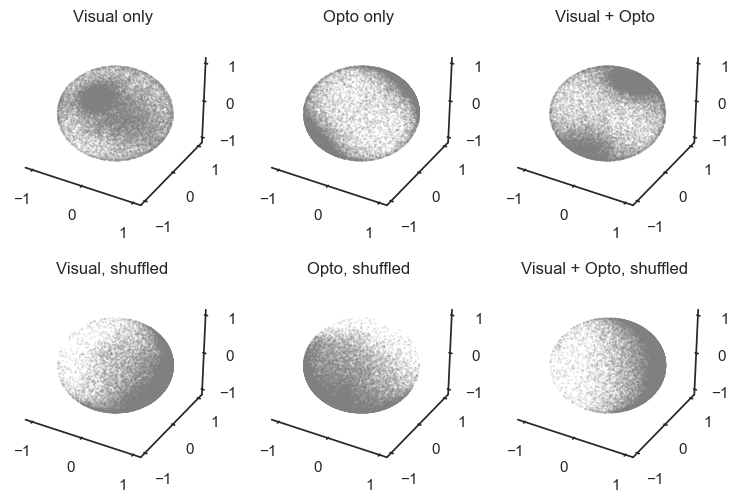

In [48]:
fig=plt.figure(figsize=(9,6))

ax1=plt.subplot(231, projection = '3d')
ax2=plt.subplot(232, projection = '3d')
ax3=plt.subplot(233, projection = '3d')
ax4=plt.subplot(234, projection = '3d')
ax5=plt.subplot(235, projection = '3d')
ax6=plt.subplot(236, projection = '3d')

ax1=cebra.plot_embedding(ax=ax1, embedding=cebra_vis, embedding_labels="grey", title='Visual only')
ax2=cebra.plot_embedding(ax=ax2, embedding=cebra_opto, embedding_labels="grey", title='Opto only')
ax3=cebra.plot_embedding(ax=ax3, embedding=cebra_visOpto, embedding_labels="grey", title='Visual + Opto')
ax4=cebra.plot_embedding(ax=ax4, embedding=cebra_vis_shuffled_train, embedding_labels="grey", title='Visual, shuffled')
ax5=cebra.plot_embedding(ax=ax5, embedding=cebra_opto_shuffled_train, embedding_labels="grey", title='Opto, shuffled')
ax6=cebra.plot_embedding(ax=ax6, embedding=cebra_visOpto_shuffled_train, embedding_labels="grey", title='Visual + Opto, shuffled')

plt.show()

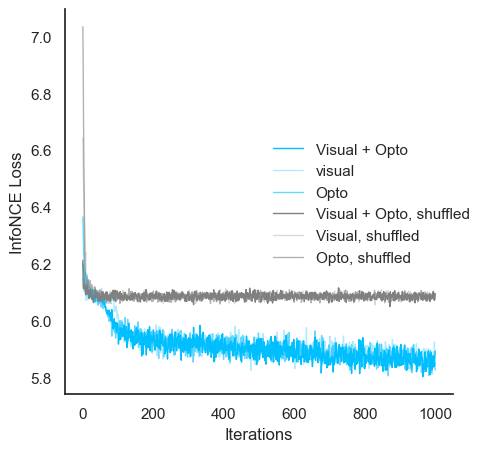

In [49]:
fig = plt.figure(figsize=(5,5))
ax = plt.subplot(111)

ax = cebra.plot_loss(cebra_visOpto_model, color='deepskyblue', label='Visual + Opto', ax=ax)
ax = cebra.plot_loss(cebra_vis_model, color='deepskyblue', alpha=0.3, label='visual', ax=ax)
ax = cebra.plot_loss(cebra_opto_model, color='deepskyblue', alpha=0.6,label='Opto', ax=ax)

ax = cebra.plot_loss(cebra_visOpto_shuffled_model, color='gray', label='Visual + Opto, shuffled', ax=ax)
ax = cebra.plot_loss(cebra_vis_shuffled_model, color='gray', alpha=0.3, label='Visual, shuffled', ax=ax)
ax = cebra.plot_loss(cebra_opto_shuffled_model, color='gray', alpha=0.6, label='Opto, shuffled', ax=ax)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_xlabel('Iterations')
ax.set_ylabel('InfoNCE Loss')
plt.legend(bbox_to_anchor=(0.5,0.3), frameon = False)
plt.show()